Epoch 1, Train Loss: 0.6065, Train Accuracy: 80.97%, Test Loss: 0.3820, Test Accuracy: 86.05%
Epoch 2, Train Loss: 0.3913, Train Accuracy: 85.86%, Test Loss: 0.3594, Test Accuracy: 86.75%


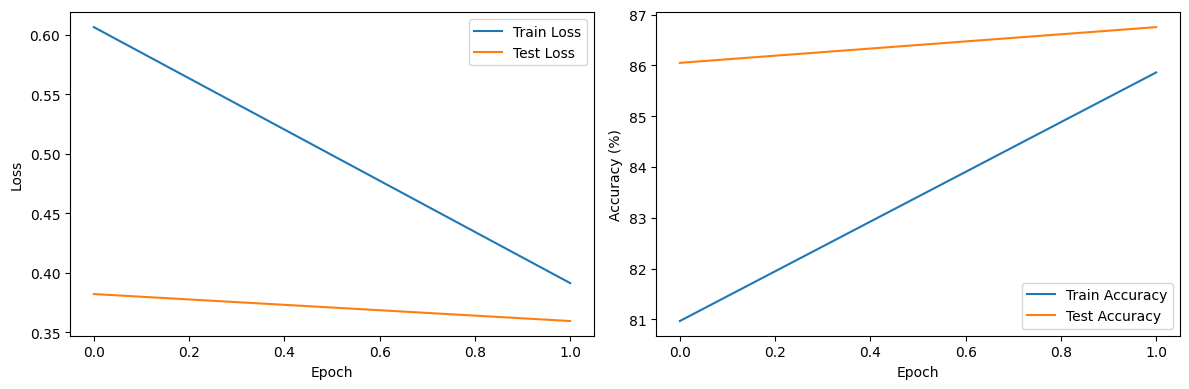

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from model import Model
from torch.utils.data import Subset
from federated_learning_system import ALPHA
from data_utils import split_non_iid_dataset

criterion = nn.CrossEntropyLoss()
optimizer_fn = lambda x: optim.Adam(x, lr=1e-3)

# 检查CUDA是否可用
device = 'cuda' if torch.cuda.is_available() else 'cpu'





# 定义转换，将数据转换为张量并进行标准化
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1736,), (0.1100,))
])

BATCH_SIZE = 4096

# 下载并加载训练数据集
train_dataset = datasets.EMNIST(root='.', split='byclass', download=True, train=True, transform=transform)

labels = train_dataset.targets.numpy()

# 下标数组随机排序
train_index = np.random.permutation(len(train_dataset))
train_index_by_client = split_non_iid_dataset(labels=labels, index=train_index, alpha=ALPHA, n_clients=1)
train_labels = [labels[idx] for idx in train_index_by_client]
train_datasets = [Subset(train_dataset, lbl) for lbl in train_labels]

# 下载并加载测试数据集
test_dataset = datasets.EMNIST(root='.', split='byclass', download=True, train=False, transform=transform)

# 创建数据加载器
train_loader = torch.utils.data.DataLoader(train_datasets[0], batch_size=BATCH_SIZE, drop_last=True,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)

# 实例化模型
model = Model()


# 训练模型
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    n_input = 0
    correct = 0
    for input, target in train_loader:
        n_input += len(input)
        input, target = input.to(device), target.to(device)
        output = model(input)
        output = output.to(device)
        loss = criterion(output, target).to(device)
        train_loss += loss.item() * len(input)
        pred = output.argmax(dim=1)  # 获取最大值的索引
        correct += torch.sum(pred == target).item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= n_input
    train_accuracy = 100. * correct / n_input
    return train_loss, train_accuracy


# 测试模型
def test(model, device, test_loader):
    model.eval()
    correct = 0
    n_input = 0
    test_loss = 0
    with torch.no_grad():
        for input, target in test_loader:
            n_input += len(input)
            input, target = input.to(device), target.to(device)
            output = model(input)
            output = output.to(device)
            loss = criterion(output, target).to(device)
            test_loss += loss.item() * len(input)
            pred = output.argmax(dim=1)  # 获取最大值的索引
            correct += torch.sum(pred == target).item()
    test_loss /= n_input
    test_accuracy = 100. * correct / n_input
    return test_loss, test_accuracy


# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 训练和测试循环
epochs = 2
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

optimizer=optimizer_fn(model.parameters())

for epoch in range(1, epochs + 1):
    train_loss, train_accuracy = train(model, device, train_loader, optimizer, epoch)
    test_loss, test_accuracy = test(model, device, test_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print(
        f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

# 可视化训练过程
plt.figure(figsize=(12, 4))

# 绘制损失
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 绘制准确度
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()
